# Setup and workflow

## Main goals

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

## Workflow

0. Load data in notebook (we are dealing with `.mat` files) (**Remark.** note that we have 3 different types of data. `glm1, glm24, glm25`)
1. Do fMRI data exploration (how does the structure look like, etc.)
    - preprocessing
2. Reorder the rows in `B`, the average activity captured by the boxcar regressor for each block (the $\beta_i$ s).

The bold signal is

$$
Y (\text{signal}) = \beta_1 x_1 + \beta_2 x_2 \dots + \beta_k x_k \\
  = \sum_i^k \beta_i x_i 
$$



3. Do ISC analysis; see (Chen et al., 2017) and [Brainiak ISC tutorial](https://brainiak.org/tutorials/10-isc/) for different levels. The repetition time (TR) is defined by the level. So for example, TR of `glm1` is one block, so 3x60s = 180s.

    - The blocks (`glm 1`); TR = 180 s
    - The levels (`glm 25`); TR = 60 s
    - The 10 seconds boxcars (`glm 24`); TR = 10 s
    
Make sure that the data is in the format brainiak wants
    
    
## Useful links

- [Brainiak ISC documentation](https://brainiak.org/docs/brainiak.html#module-brainiak.isc)
- [Brainiak specific examples](https://github.com/brainiak/brainiak/tree/master/examples)

In [1]:
#dir(brainiak)

In [2]:
import pkg_resources
pkg_resources.get_distribution("brainiak").version # iscBrainIAK v0.8. It should be installing v0.10.

'0.10'

In [58]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import hdf5storage
import mat73
import pandas as pd

%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


# GLM1 (blocks)

# 0. Loading in the data

In [5]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory
os.path.exists(data_dir) 

True

from [here](https://stackoverflow.com/questions/874461/read-mat-files-in-python) and [scipy docu](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.loadmat.html)
```
Neither scipy.io.savemat, nor scipy.io.loadmat work for MATLAB arrays version 7.3. But the good part is that MATLAB version 7.3 files are hdf5 datasets. So they can be read using a number of tools, including NumPy.
```

We want to access the following variables in the dataset (8 subjects):
- `B = [blocks, voxels]`:  the average activity in each block (BOLD signal). The whole brain data; $B =$ all fMRI data * mask. 
    - rows: blocks (recall that each block has 3 levels)
    - cols: voxels
- `names = [18,1]` : the names of the games. *note*: this is a matlab cell array, needs special treatment [link](https://databasefaq.com/index.php/answer/256550/python-matlab-h5py-reading-a-matlabs-cell-array-saved-as-a-v73-mat-file-with-h5py)
- `Vmask = [1,1] array with 8 fields` : can be used to convert mask to standardised brain coordinates
- `mask = [79, 95, 79]` : binary mask that was used to get `B` from all the fMRI data.

In [6]:
# specify filename
filename = 'beta_series_glm1_subj1_nosmooth.mat'

In [7]:
# each subject is a separate file so
subject = h5py.File(data_dir+filename,'r')

list(subject.keys()) # these are the variables in the data

['#refs#', 'B', 'Vmask', 'mask', 'names']

In [8]:
# now we read in all the variables of interest for a given subject
B = subject['B'].value
mask = subject['mask'].value
names = subject['names']
Vmask = subject['Vmask']

# # alternatively, using dictionary syntax..
# B = subject['B']

# Vmask is nested
list(Vmask.keys())

['descrip', 'dim', 'dt', 'fname', 'mat', 'n', 'pinfo', 'private']

In [9]:
names.dtype.kind # check what kind of data 'names' is

'O'

In [10]:
names

<HDF5 dataset "names": shape (1, 18), type "|O">

In [11]:
names[0] # we need to dereference each reference in the dataset

array([<HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>,
       <HDF5 object reference>, <HDF5 object reference>], dtype=object)

### Reading in matlab cell arrays into Python is a pain

Made a function to translate matlab cell arrays into list of strings :-) [here](https://stackoverflow.com/questions/46733052/read-hdf5-file-into-numpy-array) and [here](http://docs.h5py.org/en/latest/refs.html)


In [12]:
def decode_variable(file, item):

    '''
    Converts matlab cell array in the form "<HDF5 object reference>" to list of strings.

    IN

    file: the path + filename 
    item: the variable in the dataset that needs to be decoded

    RETURNS

    readable_data: np array of strings
    '''

    # Open file                                                                                    
    myfile = h5py.File(file,'r')
    variable = myfile[item] # get the names variable

    readable_data = [] # store the ne


    for var in variable: # encode and decode the objects, 18 per subject
        for v in var: # Read the references  

            #print(v)
            ds = myfile[v]
            #print(ds)
            data = ds[:]

            # store the decoded data
            word = []
            
            for i in data:
                letter = str(chr(i))  # the chr() function returns the character that represents the specified unicode.
                word.append(letter)
            word = ''.join(word) # join list of strings
            
            readable_data.append(word)
            
    return np.array(readable_data)

In [13]:
decode_variable(data_dir+filename, 'names')

array(['Sn(1) vgfmri3_chase*bf(1)', 'Sn(1) vgfmri3_lemmings*bf(1)',
       'Sn(1) vgfmri3_bait*bf(1)', 'Sn(2) vgfmri3_plaqueAttack*bf(1)',
       'Sn(2) vgfmri3_helper*bf(1)', 'Sn(2) vgfmri3_zelda*bf(1)',
       'Sn(3) vgfmri3_lemmings*bf(1)', 'Sn(3) vgfmri3_plaqueAttack*bf(1)',
       'Sn(3) vgfmri3_zelda*bf(1)', 'Sn(4) vgfmri3_chase*bf(1)',
       'Sn(4) vgfmri3_bait*bf(1)', 'Sn(4) vgfmri3_helper*bf(1)',
       'Sn(5) vgfmri3_zelda*bf(1)', 'Sn(5) vgfmri3_chase*bf(1)',
       'Sn(5) vgfmri3_lemmings*bf(1)', 'Sn(6) vgfmri3_helper*bf(1)',
       'Sn(6) vgfmri3_plaqueAttack*bf(1)', 'Sn(6) vgfmri3_bait*bf(1)'],
      dtype='<U32')

Get all the data for the glm1 files (subjects 1-8)

In [14]:
num_subjects = 8

B_data = []
mask_data = []
Vmask_data = []
names_data = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series/'
    filename = 'beta_series_glm1_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    Vmask = subject['Vmask']
    
    # === decode block names ===
    names = decode_variable(data_dir+filename, 'names')
    
    # append to lists
    B_data.append(B)
    mask_data.append(mask)
    Vmask_data.append(Vmask)
    names_data.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


## 1. Explore & Check data

Check data shapes 

**Assumption.** <font color=red> the difference e.g. `Sn(3) vgfmri3_zelda*bf(1)` and `'Sn(2) vgfmri3_zelda*bf(1)' is the level  </font>

In [15]:
B_data[0].shape

(179595, 18)

In [16]:
mask_data[0].shape

(79, 95, 79)

In [17]:
Vmask_data[0]

<HDF5 group "/Vmask" (8 members)>

In [18]:
names_data[0].shape

(18,)

In [19]:
print(names_data[5][0])

print(names_data[1][0])

# looks good, order is different

Sn(1) vgfmri3_helper*bf(1)
Sn(1) vgfmri3_lemmings*bf(1)


In [20]:
len(names_data[0])

18

In [21]:
np.unique(names_data[0]) 

array(['Sn(1) vgfmri3_bait*bf(1)', 'Sn(1) vgfmri3_chase*bf(1)',
       'Sn(1) vgfmri3_lemmings*bf(1)', 'Sn(2) vgfmri3_helper*bf(1)',
       'Sn(2) vgfmri3_plaqueAttack*bf(1)', 'Sn(2) vgfmri3_zelda*bf(1)',
       'Sn(3) vgfmri3_lemmings*bf(1)', 'Sn(3) vgfmri3_plaqueAttack*bf(1)',
       'Sn(3) vgfmri3_zelda*bf(1)', 'Sn(4) vgfmri3_bait*bf(1)',
       'Sn(4) vgfmri3_chase*bf(1)', 'Sn(4) vgfmri3_helper*bf(1)',
       'Sn(5) vgfmri3_chase*bf(1)', 'Sn(5) vgfmri3_lemmings*bf(1)',
       'Sn(5) vgfmri3_zelda*bf(1)', 'Sn(6) vgfmri3_bait*bf(1)',
       'Sn(6) vgfmri3_helper*bf(1)', 'Sn(6) vgfmri3_plaqueAttack*bf(1)'],
      dtype='<U32')

We stick to the recommended sequence of steps for running ISC using Brainiak
1. **Data preparation**. `B` is already the masked or whole brain data, so we should be able to do the ISC on this BOLD data.

How to get `B` into the right shape?


> Optional: could apply more masks to filter for specific ROI's (<font color=red>mPFC, mOFC, Hippocampus, dmPFC, PMC, diPFC, dorsal caudate, ... more? </font>)
 
2. **Compute ISC**. The ISC function computes correlations across subjects for corresponding voxels in the mask. It uses the compute_correlation function in BrainIAK, which is optimized for fast execution (and was used in FCMA).




3. **Permutation test for ISC**. Perform statistical analysis to determine significant correlation values for ISC


We can get the coordinates of the voxels by getting the indices where mask == 1

<font color=red> TODO: momchil comment: check if this is the same as matlab results. </font>

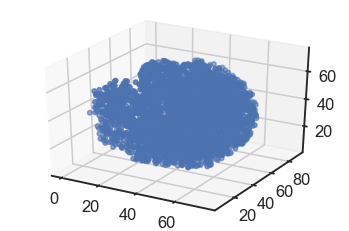

In [22]:
coords = np.where(mask_data[0] == 1) # sidenote: np.where is equivalent to matlabs find()

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(coords[0][::50], coords[1][::50], coords[2][::50]);# plot only every 50 indices (faster)

## 2. Reorder

<font color=red>Ordered the BOLD data `B` so that all the blocks `names` are in the same order. Only after this is done, the ISC can be done (see notes).</font>

- Each subject played the games in a randomised, so different order
- In order to do a valid ISC we have to reorganise `B = [blocks, voxels]` so that all have the same order of blocks. 
- How to Reorganise `B`? Use the variable `names`
    - load in as pandas dataframe
    - append `names` as left column to `B`
    - perform row operations based on `names` so that all games are in the same order [pandas sort algorithm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)
    - get back to array form
- Eventually we want to end up with a 3 dim matrix of `[blocks, voxels, subjects]`

In [23]:
# == choose a subject for which to inspect the data ==
sub = 0

# get the betas and game order from this
B_s = B_data[sub].T # transpose to get [blocks, voxels]
names_s = names_data[sub]

B_s.shape

(18, 179595)

In [57]:
# block = 1
# f, ax = plt.subplots(1,1, figsize=(20,5))
# ax.plot(B_s[block, :]); # one block, all voxels
# ax.set_title(f'BOLD signal across voxels in block {block} for subject {sub+1}')
# ax.set_xlabel('Voxel number')
# ax.set_ylabel('Voxel Intensity');

In [25]:
names_s # note that Sn(1)

array(['Sn(1) vgfmri3_chase*bf(1)', 'Sn(1) vgfmri3_lemmings*bf(1)',
       'Sn(1) vgfmri3_bait*bf(1)', 'Sn(2) vgfmri3_plaqueAttack*bf(1)',
       'Sn(2) vgfmri3_helper*bf(1)', 'Sn(2) vgfmri3_zelda*bf(1)',
       'Sn(3) vgfmri3_lemmings*bf(1)', 'Sn(3) vgfmri3_plaqueAttack*bf(1)',
       'Sn(3) vgfmri3_zelda*bf(1)', 'Sn(4) vgfmri3_chase*bf(1)',
       'Sn(4) vgfmri3_bait*bf(1)', 'Sn(4) vgfmri3_helper*bf(1)',
       'Sn(5) vgfmri3_zelda*bf(1)', 'Sn(5) vgfmri3_chase*bf(1)',
       'Sn(5) vgfmri3_lemmings*bf(1)', 'Sn(6) vgfmri3_helper*bf(1)',
       'Sn(6) vgfmri3_plaqueAttack*bf(1)', 'Sn(6) vgfmri3_bait*bf(1)'],
      dtype='<U32')

In [26]:
def cleanup_names(s):

    for r in (('vgfmri3_', ''), ('*bf(1)', ''), ('Sn(', '')):
        s = s.replace(*r)
        
    return s

In [27]:
block_names = []

for name in names_s:
    stripped_name = cleanup_names(name)
    block_names.append(stripped_name)

In [28]:
# want to order this
block_names

['1) chase',
 '1) lemmings',
 '1) bait',
 '2) plaqueAttack',
 '2) helper',
 '2) zelda',
 '3) lemmings',
 '3) plaqueAttack',
 '3) zelda',
 '4) chase',
 '4) bait',
 '4) helper',
 '5) zelda',
 '5) chase',
 '5) lemmings',
 '6) helper',
 '6) plaqueAttack',
 '6) bait']

In [29]:
# read in B as pandas df
df = pd.DataFrame(B_s)
df.insert(0, 'blocks', block_names) # insert block names as first col

df

,blocks,0,1,2,3,4,5,6,7,8,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
0,1) chase,13.678534,19.717096,1.222979,-4.251091,6.807140,1.490849,-9.897692,10.267058,6.932566,...,17.966171,5.093922,10.200910,24.991861,-8.413091,-8.126126,6.747587,-9.610495,-14.543383,-20.066061
1,1) lemmings,9.340469,14.893038,3.482431,8.328746,2.067947,7.053865,-3.198863,-4.350846,3.748187,...,21.419283,8.234531,13.862604,14.725319,-5.711393,-8.503519,-0.674800,-38.048695,-4.195394,-7.664783
2,1) bait,8.191047,18.610971,3.931173,8.562959,11.142619,2.641228,-5.400310,3.904763,2.850767,...,25.629944,12.172116,12.206659,8.205688,-0.708720,-2.572564,-3.245649,-41.123714,-0.500129,-4.736197
3,2) plaqueAttack,-5.768051,3.434072,4.085857,0.552621,-8.581039,6.450201,5.748111,6.094631,7.281043,...,24.493263,15.773898,-1.629072,1.320592,-1.860331,-8.045016,10.680734,33.953304,12.533324,27.066385
4,2) helper,4.119259,8.947463,12.726330,9.378189,-1.220948,11.692106,5.958652,5.073729,8.574687,...,6.723979,10.334471,-3.384736,-0.009358,-1.735211,-11.919559,8.367201,19.897381,24.467892,27.883690
5,2) zelda,7.021592,9.343513,11.676348,11.955696,3.066959,11.286689,10.009387,9.561795,9.748417,...,12.802929,23.510094,-4.053125,-0.571480,-3.777835,-8.239130,11.177244,-16.012350,26.567398,7.366623
6,3) lemmings,0.043728,-1.043097,-4.179738,-3.065058,-8.868436,-15.159046,-5.583825,-1.595291,3.187812,...,23.756556,11.281951,1.957970,10.599979,13.745110,9.554928,-10.555696,23.845291,-7.076766,-15.550484
7,3) plaqueAttack,2.072475,6.689902,7.172602,4.623752,-4.035094,-3.138475,-3.642266,0.053200,-0.432040,...,22.332809,6.706408,3.093272,14.604948,13.677283,12.252034,-4.183152,33.898113,-1.924500,-4.970423
8,3) zelda,8.351169,21.711334,18.740585,15.737837,2.020320,6.704339,-7.124405,-1.775580,4.791605,...,16.111681,5.501110,5.371235,8.534523,14.881846,7.707860,0.504144,16.564280,10.031107,0.628726
9,4) chase,-4.762638,-1.359534,-9.443146,-8.284603,-3.121179,-1.042376,-11.546381,-4.506612,-1.719461,...,0.234043,4.825530,-1.052109,-1.777197,-4.887089,-6.286245,1.765989,-42.126713,-12.262952,-11.136387


In [30]:
dfOrdered = df.sort_values(by='blocks') # reorder the matrix based on the 'blocks' column

dfOrdered # now the B matrix is in a specific order

,blocks,0,1,2,3,4,5,6,7,8,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
2,1) bait,8.191047,18.610971,3.931173,8.562959,11.142619,2.641228,-5.400310,3.904763,2.850767,...,25.629944,12.172116,12.206659,8.205688,-0.708720,-2.572564,-3.245649,-41.123714,-0.500129,-4.736197
0,1) chase,13.678534,19.717096,1.222979,-4.251091,6.807140,1.490849,-9.897692,10.267058,6.932566,...,17.966171,5.093922,10.200910,24.991861,-8.413091,-8.126126,6.747587,-9.610495,-14.543383,-20.066061
1,1) lemmings,9.340469,14.893038,3.482431,8.328746,2.067947,7.053865,-3.198863,-4.350846,3.748187,...,21.419283,8.234531,13.862604,14.725319,-5.711393,-8.503519,-0.674800,-38.048695,-4.195394,-7.664783
4,2) helper,4.119259,8.947463,12.726330,9.378189,-1.220948,11.692106,5.958652,5.073729,8.574687,...,6.723979,10.334471,-3.384736,-0.009358,-1.735211,-11.919559,8.367201,19.897381,24.467892,27.883690
3,2) plaqueAttack,-5.768051,3.434072,4.085857,0.552621,-8.581039,6.450201,5.748111,6.094631,7.281043,...,24.493263,15.773898,-1.629072,1.320592,-1.860331,-8.045016,10.680734,33.953304,12.533324,27.066385
5,2) zelda,7.021592,9.343513,11.676348,11.955696,3.066959,11.286689,10.009387,9.561795,9.748417,...,12.802929,23.510094,-4.053125,-0.571480,-3.777835,-8.239130,11.177244,-16.012350,26.567398,7.366623
6,3) lemmings,0.043728,-1.043097,-4.179738,-3.065058,-8.868436,-15.159046,-5.583825,-1.595291,3.187812,...,23.756556,11.281951,1.957970,10.599979,13.745110,9.554928,-10.555696,23.845291,-7.076766,-15.550484
7,3) plaqueAttack,2.072475,6.689902,7.172602,4.623752,-4.035094,-3.138475,-3.642266,0.053200,-0.432040,...,22.332809,6.706408,3.093272,14.604948,13.677283,12.252034,-4.183152,33.898113,-1.924500,-4.970423
8,3) zelda,8.351169,21.711334,18.740585,15.737837,2.020320,6.704339,-7.124405,-1.775580,4.791605,...,16.111681,5.501110,5.371235,8.534523,14.881846,7.707860,0.504144,16.564280,10.031107,0.628726
10,4) bait,-8.513804,-8.147409,-20.278408,-19.018339,-7.417134,-8.098804,-13.436254,-1.804174,-1.931729,...,4.926886,9.518762,5.451601,2.390419,0.279032,6.639667,2.165422,38.382492,-13.136907,-9.959997


In [31]:
dfOrdered = dfOrdered.drop('blocks', 1) # don't need the column with the block names anymore

In [32]:
B_ordered = dfOrdered.values # convert df to numpy array

B_ordered.shape

(18, 179595)

## 2. Reorder data for all subjects

In [60]:
def get_in_shape(B_s, names_s):
    
    '''
    Massages data into right shape for the ISC: [TRs, voxels, subjects] - bunch of stacked matrices
    
    IN
    
    B: the bold data for subject s
    names: the order of the blocks for subject s
    
    OUT
    
    dfOrdered: the ordered df, just to sanity check the reordering
    B_ordered: the ordered B array [blocks, voxels]
    '''
    
    #print(B_s.shape)
    
    # cleanup the block names first, remove stuff
    
    block_names = []

    for name in names_s:
        stripped_name = cleanup_names(name)
        block_names.append(stripped_name)
    
    #print(block_names)
    
    # read in B as pandas df
    df = pd.DataFrame(B_s)
    df.insert(0, 'block', block_names) # insert block names as first col
    
    dfOrdered = df.sort_values(by='block') # reorder the matrix based on the 'blocks' column
    dfBold = dfOrdered.drop('block', 1) # don't need the column with the block names anymore
    
    B_ordered = dfBold.values # convert df to numpy array
    
    return dfOrdered, B_ordered

In [62]:
ISC_data = []
ordered_dfs = []


for s in range(num_subjects):
    
    print(f'Preprocess fMRI data for subject {s+1}')
    # get the betas and game order from this
    B_s = B_data[s].T # transpose to get [blocks, voxels]
    names_s = names_data[s]
    
    dfOrdered, B_ordered = get_in_shape(B_s, names_s)
    
    ISC_data.append(B_ordered)
    ordered_dfs.append(dfOrdered)
    
ISC_arr = np.array(ISC_data)

Preprocess fMRI data for subject 1
Preprocess fMRI data for subject 2
Preprocess fMRI data for subject 3
Preprocess fMRI data for subject 4
Preprocess fMRI data for subject 5
Preprocess fMRI data for subject 6
Preprocess fMRI data for subject 7
Preprocess fMRI data for subject 8


In [63]:
ordered_dfs[0]

,block,0,1,2,3,4,5,6,7,8,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
2,1) bait,8.191047,18.610971,3.931173,8.562959,11.142619,2.641228,-5.400310,3.904763,2.850767,...,25.629944,12.172116,12.206659,8.205688,-0.708720,-2.572564,-3.245649,-41.123714,-0.500129,-4.736197
0,1) chase,13.678534,19.717096,1.222979,-4.251091,6.807140,1.490849,-9.897692,10.267058,6.932566,...,17.966171,5.093922,10.200910,24.991861,-8.413091,-8.126126,6.747587,-9.610495,-14.543383,-20.066061
1,1) lemmings,9.340469,14.893038,3.482431,8.328746,2.067947,7.053865,-3.198863,-4.350846,3.748187,...,21.419283,8.234531,13.862604,14.725319,-5.711393,-8.503519,-0.674800,-38.048695,-4.195394,-7.664783
4,2) helper,4.119259,8.947463,12.726330,9.378189,-1.220948,11.692106,5.958652,5.073729,8.574687,...,6.723979,10.334471,-3.384736,-0.009358,-1.735211,-11.919559,8.367201,19.897381,24.467892,27.883690
3,2) plaqueAttack,-5.768051,3.434072,4.085857,0.552621,-8.581039,6.450201,5.748111,6.094631,7.281043,...,24.493263,15.773898,-1.629072,1.320592,-1.860331,-8.045016,10.680734,33.953304,12.533324,27.066385
5,2) zelda,7.021592,9.343513,11.676348,11.955696,3.066959,11.286689,10.009387,9.561795,9.748417,...,12.802929,23.510094,-4.053125,-0.571480,-3.777835,-8.239130,11.177244,-16.012350,26.567398,7.366623
6,3) lemmings,0.043728,-1.043097,-4.179738,-3.065058,-8.868436,-15.159046,-5.583825,-1.595291,3.187812,...,23.756556,11.281951,1.957970,10.599979,13.745110,9.554928,-10.555696,23.845291,-7.076766,-15.550484
7,3) plaqueAttack,2.072475,6.689902,7.172602,4.623752,-4.035094,-3.138475,-3.642266,0.053200,-0.432040,...,22.332809,6.706408,3.093272,14.604948,13.677283,12.252034,-4.183152,33.898113,-1.924500,-4.970423
8,3) zelda,8.351169,21.711334,18.740585,15.737837,2.020320,6.704339,-7.124405,-1.775580,4.791605,...,16.111681,5.501110,5.371235,8.534523,14.881846,7.707860,0.504144,16.564280,10.031107,0.628726
10,4) bait,-8.513804,-8.147409,-20.278408,-19.018339,-7.417134,-8.098804,-13.436254,-1.804174,-1.931729,...,4.926886,9.518762,5.451601,2.390419,0.279032,6.639667,2.165422,38.382492,-13.136907,-9.959997


In [64]:
ordered_dfs[1]

,block,0,1,2,3,4,5,6,7,8,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
1,1) chase,-8.913073,4.931581,-4.048117,-11.821495,-18.338636,-0.092433,-4.669257,5.255018,12.378554,...,3.185611,4.861215,-4.222706,2.874815,0.200186,-1.283935,-13.665998,4.194106,0.144150,12.240763
0,1) lemmings,-1.125007,8.983638,-4.304861,-0.020633,-15.692051,0.136040,-6.097048,9.362468,8.820086,...,0.896400,5.275642,1.382844,2.072187,-7.988295,-4.395771,-15.532010,0.684985,-1.857348,5.419982
2,1) plaqueAttack,-6.694045,-1.383151,-7.458098,-14.556552,-17.709612,1.340206,-3.703244,-3.572592,7.572104,...,0.108595,8.701091,-5.477293,2.869280,7.816778,-4.666004,-7.019289,-1.760028,7.769444,17.389513
4,2) bait,21.827042,14.551542,4.011669,-0.186228,25.424334,46.654095,4.816082,10.287361,11.047503,...,0.171770,1.876647,5.029555,-0.531584,14.497522,2.703888,4.289207,9.684872,-4.514864,10.337736
3,2) helper,12.017437,4.945107,4.476936,0.627717,11.892717,10.506105,4.901250,0.430348,0.813818,...,-6.310804,0.955340,4.674149,-6.436330,12.664268,-1.402642,3.064172,-4.289654,-2.062634,2.030088
5,2) zelda,8.446783,16.341030,10.680388,10.878026,8.928246,17.952438,-0.061725,2.518940,7.503181,...,1.255736,-0.014796,4.121192,-1.293590,12.799404,-0.252538,5.974134,10.034698,-0.959029,7.876016
8,3) lemmings,-20.600538,-23.069891,-16.197380,-22.795635,-22.915983,-15.247155,-7.480081,-12.622875,-17.284286,...,10.281489,-0.218104,-3.599467,-8.885350,2.500748,2.370899,-1.943034,4.256172,-9.344553,-13.932338
6,3) plaqueAttack,-21.897417,-12.947967,-15.842909,-15.813840,-19.265490,-19.099112,-15.252425,-8.070543,-13.663619,...,-2.997967,-2.792976,-7.488853,-5.283305,-1.962311,0.573118,-6.642441,-3.009807,-3.778186,-6.590477
7,3) zelda,-25.064451,-14.309290,-3.335352,-12.617905,-19.596058,-25.682127,-14.675658,-25.397537,-30.092432,...,2.106013,-5.342669,-5.624668,-24.118362,1.404231,-2.317847,-9.732985,3.301303,-2.820230,-9.609191
9,4) bait,-4.424935,-1.146451,-11.092004,-13.545979,-7.821805,4.644570,-5.998487,1.805380,-2.930921,...,-3.201290,-0.414744,-10.742618,-3.548619,-3.490303,-4.393771,-9.322300,-2.687937,-5.336979,-2.923342


In [35]:
ISC_arr.shape # wrong shape

(8, 18, 179595)

In [36]:
ISC_arr = np.swapaxes(ISC_arr, 0, 1) # need to get [TRs, voxels, subjects]
ISC_arr = np.swapaxes(ISC_arr, 1, 2)

ISC_arr.shape

(18, 179595, 8)

# 3. Compute ISC

We perform an ISC in two different ways. 

## 3.1 Do ISC and obtain a matrix

We can do an ISC either by treating each row (**block**) as a variable, or by treating each column (**voxel**) as a variable.

### Correlating the voxel patterns of the respective blocks

- In the study from (Chen et al., 2016) they divided the BOLD data obtained from watching and recalling a Sherlock movie up in 50 scenes. This resulted in one vector voxel values for each recalled scene. As such, they compute the correlation between every matching pair of recalled scenes (see img top right).
- In our case, this is equivalent to treating block, **row**, as a variable.
- <font color=red>TODO: explain results (clusters, etc) </font> 

### Correlating the voxel time series

- In our data, the blocks represent the time component, so the voxel time series for a voxel $v$ is one column in the matrix.
- Let $v=3$, then we want to know how much the column $v=3$ from subject $s$ is correlated with the average of the time series of column $3$ from all other participants.

<img src="http://drive.google.com/uc?export=view&id=1T44u4Vwb-TcmWvjFNSq_HGGvbF5FYl-8" style="height:400px"/>

### Correlate voxel time series 

Running this results in a dead kernel. One potential option to prevent [this](https://stackoverflow.com/questions/52427933/how-to-calculate-a-very-large-correlation-matrix)

In [37]:
# compute mean matrix of 7 matrices
sub = 2 # choose a subject

M_sub = ISC_arr[:,:,sub] # take only subject matrix
M_rest = np.delete(ISC_arr, sub, axis=2) # remove this subjects' data from data

print(M_sub.shape)
print(M_rest.shape)

# compute average of other matrices
M_rest_mean = np.mean(M_rest, axis=2)

M_rest_mean.shape

(18, 179595)
(18, 179595, 7)


(18, 179595)

In [ ]:
# now compute correlation between mean matrix & subj matrix --> dead kernel
C_voxtimeseries = np.corrcoef(M_sub, M_rest_mean, rowvar=False)
print(C_voxtimeseries.shape)

f, ax = plt.subplots(1,1, dpi=100)
f.suptitle(f'ISC with subject {sub+1}')
sns.heatmap(C_voxtimeseries, cmap='coolwarm', ax=ax);

### Correlate voxel patterns of respective blocks

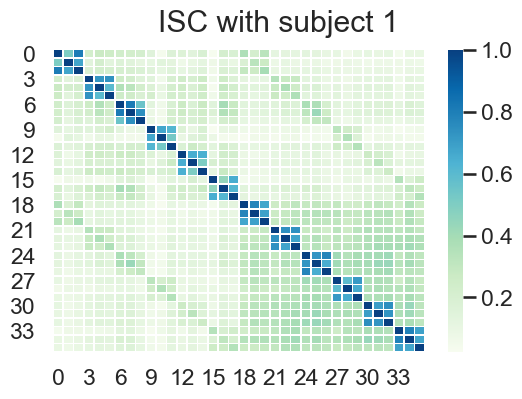

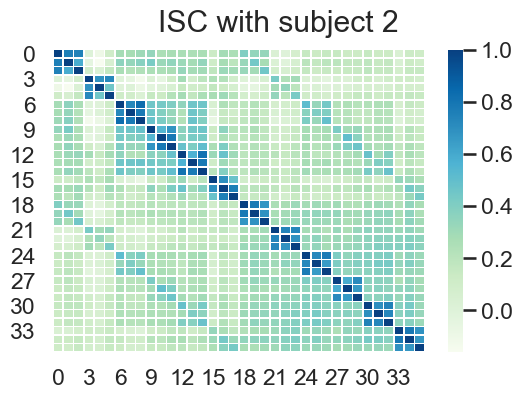

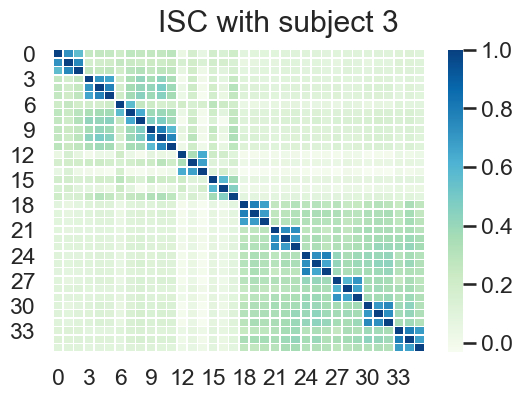

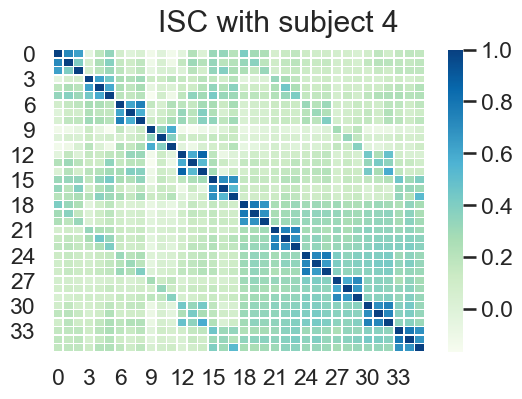

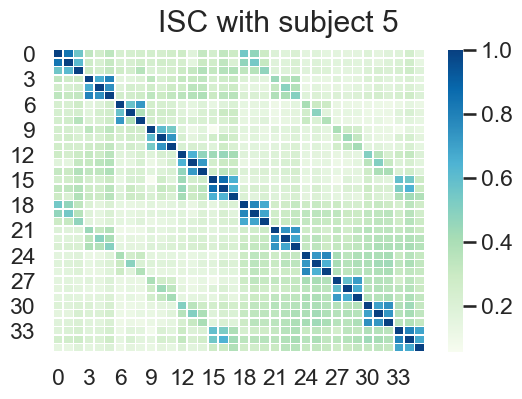

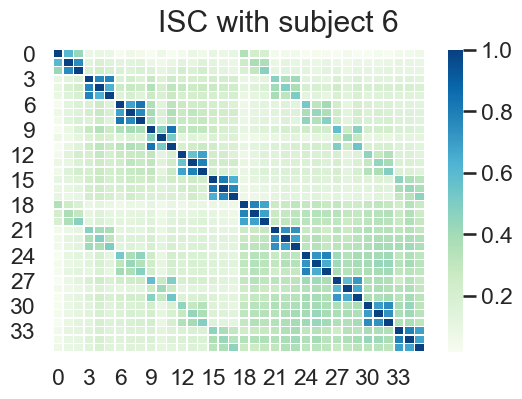

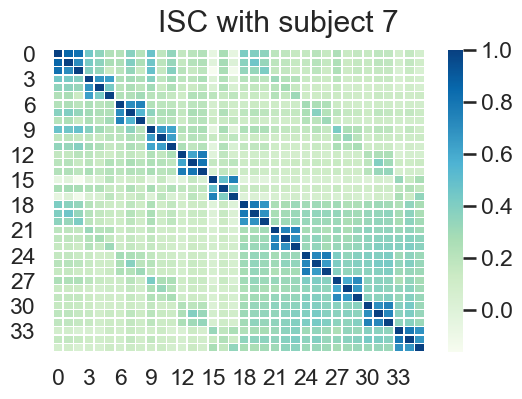

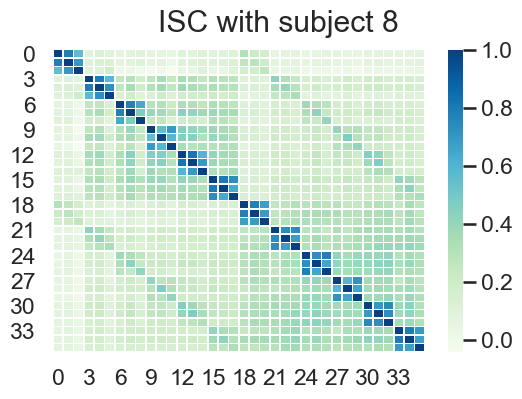

In [56]:
for i in range(num_subjects):
    
    M_sub = ISC_arr[:,:,i] # take the subject matrix 
    M_rest = np.delete(ISC_arr, i, axis=2) # remove this subjects' data from whole dataset
    # now compute correlation between mean matrix & subj matrix
    C_blockpatterns = np.corrcoef(M_sub, M_rest_mean, rowvar=True) # treat rows as variables
    
    f, ax = plt.subplots(1,1, dpi=100)
    f.suptitle(f'ISC with subject {i+1}')
    sns.heatmap(C_blockpatterns, cmap='GnBu', ax=ax, linewidth=0.3);
    
## use this if want to trop upper half
#     mask = np.zeros_like(C_blockpatterns)
#     mask[np.triu_indices_from(mask)] = True
#     with sns.axes_style("white"):
#         f, ax = plt.subplots(1,1, dpi=100)
#         f.suptitle(f'ISC with subject {i+1}')
#         ax = sns.heatmap(C_blockpatterns, cmap='YlGnBu', mask=mask, vmax=.3, square=True)


## 3.2 ISC with Brainiak


## How to work with `.nii` data

<font color=red>TODO: complete this tutorial</font> 

[nifti data tutorial](https://dartbrains.org/features/notebooks/3_Introduction_to_NeuroimagingData_in_Python.html)

[nibabel docs](https://nipy.org/nibabel/nibabel_images.html#loading-and-saving)

### About `ISC(data)`

We correlate each voxel to each other respective voxel directly using the build in `isc()` method.

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data.

- expects: `data (list or ndarray (n_TRs x n_voxels x n_subjects))` – fMRI data for which to compute ISC

- For each voxel or ROI, compute the Pearson correlation between each subject’s response time series and other subjects’ response time series. 
- Output is an ndarray where the first dimension is the number of subjects or pairs and the second dimension is the number of voxels (or ROIs). If only two subjects are supplied or a summary statistic is invoked, the output is a ndarray n_voxels long.

based on work in (Hasson 2004).

In [44]:
isc_maps = isc(ISC_arr, pairwise=False) # The output of ISC is a voxel by 
                           # participant matrix (showing the result of each individual with the group).

In [45]:
isc_maps.shape # The output of ISC is subjects x voxels

(8, 179595)

In [46]:
isc_maps

array([[ 0.27141404,  0.38958313,  0.38850114, ...,  0.31426416,
         0.20801356, -0.06619789],
       [-0.10634228,  0.29056467,  0.35181735, ..., -0.16632542,
         0.05281726,  0.09085218],
       [ 0.53980921,  0.28981233,  0.45037416, ...,  0.24245405,
         0.56515957, -0.2053742 ],
       ...,
       [ 0.20601254, -0.29613722,  0.43698773, ..., -0.07314849,
         0.08948639,  0.37530218],
       [-0.11041902, -0.1271092 , -0.40551652, ..., -0.46277586,
        -0.33732751, -0.21438313],
       [ 0.47840461,  0.35921369,  0.1489104 , ...,  0.34571446,
         0.32853423, -0.32193906]])

`compute_summary_statistic`: computes summary statistics for ISCs

Computes either the ‘mean’ or ‘median’ across a set of ISCs. In the case of the mean, ISC values are first Fisher Z transformed (arctanh), averaged, then inverse Fisher Z transformed (tanh).

In [47]:
compute_summary_statistic(isc_maps, summary_statistic='median')

0.002024672570628622

In [48]:
compute_summary_statistic(isc_maps, summary_statistic='mean')

0.0020531110897292954

### visualize the ISC matrix for one participant and condition back on to the brain to see where activity is correlated between participants.

In [49]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory

# load in the nift data using nibabel module
brain_nii = nib.load(os.path.join(data_dir, 'mean.nii'))

In [50]:
brain_nii.get_data()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [51]:
brain_nii.shape

(157, 189, 156)

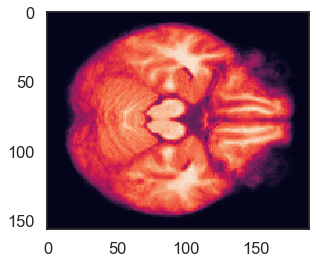

In [52]:
# directly access the data and plot a single slice using standard matplotlib functions.
plt.imshow(brain_nii.get_data()[:,:,50]); 

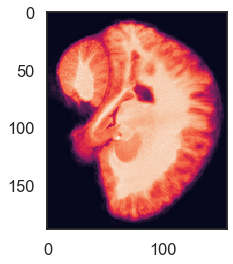

In [54]:
plt.imshow(brain_nii.get_data()[100, :, :])

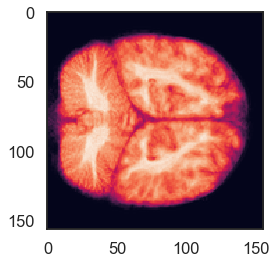

In [56]:
plt.imshow(brain_nii.get_data()[:, 50, :])

In [120]:
header = brain_nii.header
print(header)   

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 157 189 156   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'spm - mean image'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -112.0
qoffset_z       : -70.0
srow_x          : [-1.  0

In [122]:
brain_nii.affine

array([[  -1.,    0.,    0.,   78.],
       [   0.,    1.,    0., -112.],
       [   0.,    0.,    1.,  -70.],
       [   0.,    0.,    0.,    1.]])

In [130]:
# choose a subject
sub = 0
# get coordinates
coords_sub = np.where(mask_data[sub] == 1) 

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)

# Map the ISC data for a subject into brain space
isc_vol[coords_sub] = isc_maps[sub,:]

# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)

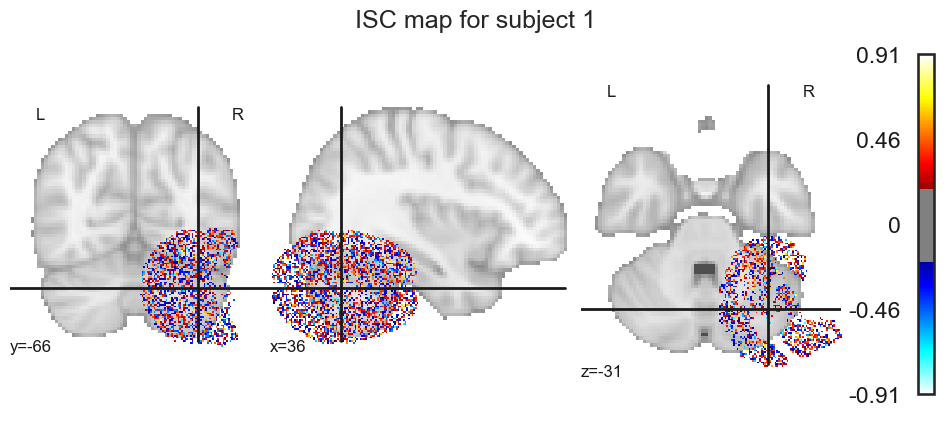

In [133]:
# Plot the data as a statmap
threshold = .2

f, ax = plt.subplots(1,1, figsize = (12, 5), dpi=100)
plotting.plot_stat_map(
    isc_nifti, 
    threshold=threshold, 
    axes=ax
)
ax.set_title(f'ISC map for subject {sub+1}');

<font color=red>TODO: Whoops. Clearly, something is going wrong here. Figure out what and after, make this map for all subjects.</font> 

## 3. Permutation test for ISC

## Useful terminology 


- trial: One presentation of the stimulus.
- block: A sequence of trials of the same category. In the 'vdc' study, e.g. a block would consist of all face -- - trials. Usually, multiple blocks are presented to the participant.
- run: A sequence of blocks presented to the participant. 
- TR: Also known as Repetition Time. It is the time interval at which pulses occur and signal is collected. It can thus be considered as the sampling period of the BOLD signal. 